In [ ]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [17]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Inner-zonal assignment
## Saves transport demand within zones
## Needs inner-zonal volumes and trip lengths by mode

In [2]:
input_path = '../input/transport_demand/'
output_path = '../output/'
model_path = '../model/'

## Load transport demand data from VP2030

The German federal government's transport study "[Bundesverkehrswegeplan 2030](https://www.bmvi.de/SharedDocs/DE/Artikel/G/BVWP/bundesverkehrswegeplan-2030-inhalte-herunterladen.html)" uses origin destination matrices on NUTS3-level resolution and makes them accessible under copyright restrictions for the base year and the year of prognosis. These matrices cannot be published in their original form.

In [3]:
vp2010 = pd.read_excel(input_path + 'PVMatrix_BVWP15_A2010.xlsx')
vp2030 = pd.read_excel(input_path + 'PVMatrix_BVWP15_P2030.xlsx')

In [4]:
print(vp2010.shape)
vp2010[vp2010.isna().any(axis=1)]

(313590, 38)


,# Quelle,Ziel,Bahn_Fz1,Bahn_Fz2,Bahn_Fz3,Bahn_Fz4,Bahn_Fz5,Bahn_Fz6,MIV_Fz1,MIV_Fz2,...,Rad_Fz3,Rad_Fz4,Rad_Fz5,Rad_Fz6,Fuß_Fz1,Fuß_Fz2,Fuß_Fz3,Fuß_Fz4,Fuß_Fz5,Fuß_Fz6


In [5]:
for df in [vp2010, vp2030]:
    df.rename(columns={'# Quelle': 'origin', 'Ziel': 'destination'}, inplace=True)

### Cast to 2017 data

In [6]:
def get_vp2017(vp2010_i, vp2030_i):
    return vp2010_i + (vp2030_i - vp2010_i) * (7/20)

In [20]:
# Calculate a OD table for the year 2017
vp2017 = get_vp2017(vp2010.set_index(['origin', 'destination']),
                    vp2030.set_index(['origin', 'destination']))

In [21]:
vp2017.dropna(how='all', inplace=True)
print(vp2010.shape)
vp2017[vp2017.isna().any(axis=1)]

(313590, 38)


,,Bahn_Fz1,Bahn_Fz2,Bahn_Fz3,Bahn_Fz4,Bahn_Fz5,Bahn_Fz6,MIV_Fz1,MIV_Fz2,MIV_Fz3,MIV_Fz4,...,Rad_Fz3,Rad_Fz4,Rad_Fz5,Rad_Fz6,Fuß_Fz1,Fuß_Fz2,Fuß_Fz3,Fuß_Fz4,Fuß_Fz5,Fuß_Fz6
origin,destination,,,,,,,,,,,,,,,,,,,,,


In [22]:
vp2017 = vp2017[list(vp2017.columns)].astype(int)
#vp2017.head()

In [23]:
# Keep only inner-cell transport demand
vp2017.reset_index(inplace=True)
vp2017 = vp2017.loc[vp2017['origin']==vp2017['destination']]
vp2017.drop('destination', axis=1, inplace=True)
len(vp2017)

412

### Update zone codes and map to NUTS

In [14]:
# NUTS3-level zones changed after the VP2030
# Thus the VP table needs to be updated manually
update_dict = {3156: 3159, 3152: 3159, # Göttingen
               13001: 13075, 13002: 13071, 13005: 13073, 13006: 13074,
               13051: 13072, 13052: 13071, 13053: 13072, 13054: 13076, 13055: 13071, 13056: 13071,
               13057: 13073, 13058: 13074, 13059: 13075, 13060: 13076, 13061: 13073, 13062: 13075}

In [24]:
# What is the sum of all trips? For Validation
cols = [c for c in vp2017.columns if c not in ['origin']]
orig_sum = vp2017[cols].sum().sum()
orig_sum

85242846874

In [25]:
# Update LAU codes
vp2017['origin'] = vp2017['origin'].replace(update_dict)

In [28]:
# Replace LAU with NUTS
sm = stepmodel.read_json(model_path + 'de_zones')
lau_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
vp2017['origin'] = vp2017['origin'].astype(str).map(lau_dict)

In [30]:
# Restrict to cells in the model
vp2017 = vp2017[~vp2017.isna().any(axis=1)]
vp2017.shape

(412, 37)

In [31]:
# What is the sum of all trips after ditching outer-German trips?
vp2017[cols].sum().sum() / orig_sum

1.0

In [32]:
# Aggregate origins
vp2017 = vp2017.groupby('origin').sum().reset_index()
vp2017[cols].sum().sum() / orig_sum

1.0

In [33]:
vp2017.shape

(401, 37)

### Re-arrange the modes and purposes

In [34]:
# Merge bicycle and foot
for p in range(1,7):
    vp2017['walk_Fz' + str(p)] = vp2017['Rad_Fz' + str(p)] + vp2017['Fuß_Fz' + str(p)]
vp2017 = vp2017[[col for col in list(vp2017.columns) if not col[:3] in ['Rad', 'Fuß']]]

In [37]:
# Make columns two levels
vp2017.set_index('origin', inplace=True)
mode_dict = {'OESPV': 'bus', 'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'walk': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[1], mode_dict[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])

In [38]:
# Merge purpose 5 and 6 due to calibration data limitations
vp2017['Fz6'] = vp2017['Fz5'] + vp2017['Fz6']
vp2017.drop('Fz5', axis=1, inplace=True)

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

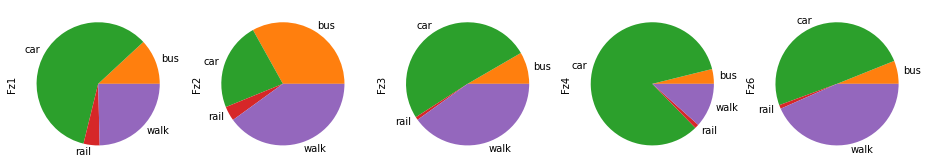

In [40]:
# Modal split by trips
vp2017.T.sum(axis=1).unstack('segment').plot.pie(
    subplots=True, figsize=(16, 4), legend=False)

In [75]:
# Ditch air columns
vp2017.drop('air', axis=1, level=1, inplace=True)

In [40]:
# Clear the RAM
vp2010 = None
vp2030 = None

In [76]:
volumes = vp2017

## Load MiD2017 data for trip lengths

Generate average trip lengths using survey data.

In [41]:
trips = pd.read_csv(input_path + 'MiD2017_Regional_Wege.csv', sep=';')
trips = trips[['KKZ_SO', 'KKZ_ZO', 'SKTYP', 'wegkm_imp', 'km_routing_gr',
               'wegmin_imp1', 'hwzweck1', 'hvm_diff2', 'vm_kombi', 'anzpers',
               'auto', 'P_FKARTE', 'multimodal', 'bahn28', 'bus28', 'bahn28_zo',
               'bus28_zo', 'W_DETAIL', 'W_SO2']]
trips.columns = ['origin', 'destination', 'SKTYP', 'distance', 'distance_routed',
                 'duration', 'purpose', 'mode', 'mode_combo', 'n_persons',
                 'car_avail', 'ticket_type', 'mode_affinity', 'dist_train_origin',
                 'dist_bus_origin', 'dist_train_destination', 'dist_bus_destination',
                 'W_DETAIL', 'W_SO2']

In [42]:
trips['distance'] = pd.to_numeric(trips['distance'].str.replace(',', '.'))

In [43]:
# Filter for inner-German trips
trips = trips.loc[(trips['W_SO2']!=2) & (trips['W_SO2']!=3)]
len(trips)

959778

In [44]:
# Filter unspecified rows
trips = trips.loc[(trips['purpose']!=99) &
                  (trips['origin']<9999) &
                  (trips['destination']<9999) &
                  (trips['mode']<24) &
                  (trips['distance_routed']!=708)]
trips = trips.loc[(trips['origin']>1) &
                  (trips['destination']>1)]
len(trips)

409507

In [45]:
# Filter for inner-zonal traffic
trips = trips.loc[trips['origin']==trips['destination']]
len(trips)

300620

In [46]:
# Remove ferries and air
trips = trips.loc[trips['mode']!=19]
trips = trips.loc[trips['mode']!=23]
len(trips)

300567

In [94]:
trips = trips.loc[trips['origin']!=1] # pandas error
len(trips)

299188

In [48]:
# Align regional specifics with urbanisation degree
mid_urbanisation_dict = {1:1, 2:2, 3:3, 4:3}
trips['urbanisation'] = trips['SKTYP'].map(mid_urbanisation_dict)

In [52]:
trips.groupby('urbanisation')['origin'].sum()

urbanisation
1    1388251383
2     376184155
3     297971806
Name: origin, dtype: int64

In [61]:
# Make unknown number of persons equal to one
trips.loc[trips['n_persons']>6] = 1

In [93]:
# Match trip purpose with VP2030 categories
# Note: Holiday trips are included in private (6)
purpose_mid_vp_dict = {1: 'Fz1', 2: 'Fz4', 3: 'Fz2', 4: 'Fz3',
                       5: 'Fz3', 6: 'Fz6', 7: 'Fz6', 99: 'Fz6'}
trips['purpose_vp'] = trips['purpose'].map(purpose_mid_vp_dict)

In [50]:
# Match mode with the model modes
# Non-motorised modes, buses, and rail are merged
mode_mid_vp_dict = {1:'walk', 2:'walk', 3:'walk', 4:'car',
                    5:'car', 6:'car', 7:'car', 8:'car', 9:'car',
                    10:'car', 11:'car', 12:'bus', 13:'bus',
                    14:'bus', 15:'bus', 16:'rail', 17:'car',
                    18:'car', 19:'walk', 20:'rail', 21:'bus',
                    22:'bus', 23:'air', 24:'walk'}
trips['mode_model'] = trips['mode'].map(mode_mid_vp_dict)

### Generate averages

In [95]:
# Count the number of observations to grasp statistical validity
trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['origin'].count().unstack('purpose_vp')

purpose_vp                 Fz1   Fz2    Fz3   Fz4    Fz6
urbanisation mode_model                                 
1            bus          4852  4694   6699   595   7467
             car         22079  4526  69573  5474  61333
             rail         1799   723    827   202   1568
             walk         1280  2256   8217   295   6387
2            bus           148  1213    278    38    323
             car          6386  1304  18784  1310  15855
             rail           78    81     35    18     77
             walk          237   477   1358    44   1189
3            bus            98   991    146    19    202
             car          5456  1049  14990  1121  12565
             rail           34    79     30    11     45
             walk          132   284   1023    36    798

In [96]:
trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['distance'].mean().unstack('purpose_vp')

purpose_vp                     Fz1        Fz2        Fz3        Fz4        Fz6
urbanisation mode_model                                                       
1            bus          7.930023   6.755196   5.254245   6.820437   6.231102
             car         11.406695   5.808237   5.488705   9.861474   7.304671
             rail        19.144558  14.014177  12.263265  34.880396  21.912022
             walk         3.046969   1.672770   1.383586   2.456610   2.285613
2            bus         13.714865   8.345260   6.777302  12.562105   8.997864
             car         11.204001   6.056863   5.661268  12.270344   7.993926
             rail        38.816667  19.104568  11.391429  22.360000  42.481039
             walk         2.191013   1.428134   1.311915   1.751364   2.124516
3            bus         10.070000   8.742260   4.902397   9.031053   8.583020
             car         11.643732   6.972135   6.132818  11.553194   7.738592
             rail        46.644412  20.314937  49.940333  66.109091  55.600889
             walk         2.712197   1.582500   1.376559   1.723056   2.050075

In [97]:
# Generate average lengths and times
len_dict = trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['distance'].mean().to_dict()
time_dict = trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['duration'].mean().to_dict()

In [98]:
# Generate average occupation factors for car trips
# Necessary to calculate vehicle kilometers
car_occ_dict = trips.loc[trips['mode_model']=='car'].groupby(
    ['urbanisation', 'purpose_vp'])['n_persons'].mean().to_dict()
trips.loc[trips['mode_model']=='car'].groupby(
    ['urbanisation', 'purpose_vp'])['n_persons'].mean().unstack('purpose_vp')

purpose_vp,Fz1,Fz2,Fz3,Fz4,Fz6
urbanisation,,,,,
1,1.149916,2.381794,1.526555,1.264889,2.073011
2,1.161134,2.431748,1.505217,1.331298,2.046925
3,1.163856,2.442326,1.502468,1.223907,2.077278


### Generate prices

See cal11 for values and explanation

In [65]:
trips['price'] = 0

In [66]:
# Car
vc_car = 0.11439257425742574 # in €/km
mask = trips['mode_model']=='car'
trips.loc[mask, 'price'] = [d*vc_car/n + 0.8*t/60 for d,n,t in zip(
    trips.loc[mask,'distance'], trips.loc[mask,'n_persons'], trips.loc[mask,'duration'])]

In [67]:
# PT (same local pricing regime for rail and bus)
# Savings through abonements:
ticket_dict = {1:1, 2:0.9, 3:0.5, 4:0, 5:0, 6:1, 7:1, 99:1, 200:1}
region_dict = {1: 2.74, 2: 4, 3: 4}
mask = trips['mode_model'].isin(['bus', 'rail'])
trips.loc[mask, 'price'] = [region_dict[r] * ticket_dict[t] for r,t in zip(
    trips.loc[mask,'urbanisation'], trips.loc[mask,'ticket_type'])]

In [99]:
# Generate averages
price_dict = trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['price'].mean().to_dict()
trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['price'].mean().unstack('purpose_vp')

purpose_vp                    Fz1       Fz2       Fz3       Fz4       Fz6
urbanisation mode_model                                                  
1            bus         0.859102  1.938138  1.143650  1.146195  1.352460
             car         1.496710  0.567988  0.660165  1.295427  0.711752
             rail        0.689798  1.601555  1.193407  1.190950  1.322819
             walk        0.000000  0.000000  0.000000  0.000000  0.000000
2            bus         2.191892  3.498104  2.654676  2.747368  2.710836
             car         1.422980  0.549150  0.662652  1.411926  0.739997
             rail        1.851282  2.656790  2.880000  2.777778  3.090909
             walk        0.000000  0.000000  0.000000  0.000000  0.000000
3            bus         2.583673  3.517255  2.698630  3.347368  2.576238
             car         1.472846  0.631857  0.705711  1.374151  0.707934
             rail        1.976471  2.886076  2.773333  2.181818  2.444444
             walk        0.000000  0.000000  0.000000  0.000000  0.000000

## Save to excel

Merge volumes and averages into a suitable output format. It should contain columns for
* volumes
* passenger kilometer
* vehicle kilometer
* av. distance
* av. time
* av. price

In [80]:
# Stack column names to columns
df = volumes.stack().stack().rename('volumes').reset_index(level=[1,2])

In [90]:
# Add urbanisation column
df['urb'] = df.index.map(sm.zones['urbanisation'].to_dict()).astype(int)

In [100]:
# Av. distance in km
df['length'] = [len_dict[a] for a in tuple(zip(df['urb'], df['mode'], df['segment']))]

In [101]:
# Av. time in h
df['time'] = [time_dict[a]/60 for a in tuple(zip(df['urb'], df['mode'], df['segment']))]

In [102]:
# Av. price in EUR
df['price'] = [price_dict[a] for a in tuple(zip(df['urb'], df['mode'], df['segment']))]

In [103]:
# Passenger kilometer
df['pkm'] = (df['volumes'] * df['length']).astype(int)

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

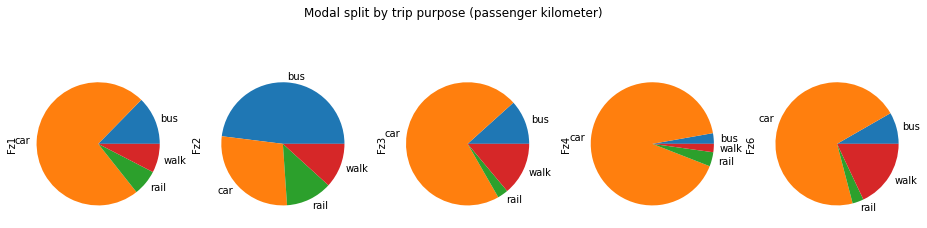

In [117]:
# Modal split by pkm
df.set_index(['mode', 'segment'], append=True)['pkm'].unstack().groupby(level=1).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

In [109]:
# Vehicle kilometer for cars
df['vkm'] = [pkm/car_occ_dict[(u,p)] if m=='car' else 0 for u,m,p,pkm in zip(
    df['urb'], df['mode'], df['segment'], df['pkm'])]

In [ ]:
# Cycling and walking is not counted to vkm
# PT km depend on the schedules
df['vkm'] = df['vkm'].astype(int)

In [111]:
# Create an aggregated version (NUTS2-level and no segments)
df['NUTS1'] = df.index.str[:3]
df_agg = df.groupby(['NUTS1', 'mode']).agg(
    {'volumes': 'sum', 'length': 'mean', 'time': 'mean',
     'price': 'mean', 'pkm': 'sum', 'vkm': 'sum'})

In [113]:
# Save an excel
with pd.ExcelWriter(output_path + 'inner_zone.xlsx') as writer:
    df.to_excel(writer, sheet_name='inner_zone')
    df_agg.to_excel(writer, sheet_name='agg')